In [5]:
# ==================== 1. ИМПОРТЫ (ОСТАЕТСЯ БЕЗ ИЗМЕНЕНИЙ) ====================
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import pickle
import os
from pathlib import Path
import gc
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from catboost import CatBoostRegressor, Pool

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
print("✅ Библиотеки загружены")

# ==================== 2. ИНКРЕМЕНТАЛЬНАЯ ЗАГРУЗКА И АГРЕГАЦИЯ ====================
print("\n" + "="*60)
print("ИНКРЕМЕНТАЛЬНАЯ ЗАГРУЗКА И АГРЕГАЦИЯ")
print("="*60)

file_paths = [
    '/content/drive/MyDrive/велики/rides_2021_optimized_filled.parquet',
    '/content/drive/MyDrive/велики/rides_2022_optimized_filled.parquet',
    '/content/drive/MyDrive/велики/rides_2023_optimized_filled.parquet',
    '/content/drive/MyDrive/велики/rides_2024_optimized_filled.parquet',
    '/content/drive/MyDrive/велики/rides_2025_optimized_filled.parquet'
]

def process_file_to_hourly(file_path, sample_frac=0.3):
    """Обрабатывает один файл и возвращает почасовые агрегаты."""
    print(f"Обработка {Path(file_path).name}...")

    try:
        # 1. Загрузка с выборкой и только нужных колонок
        usecols = ['started_at', 'ended_at', 'start_station_id', 'end_station_id']
        df = pd.read_parquet(file_path, columns=usecols)
        df = df.sample(frac=sample_frac, random_state=42) if sample_frac < 1 else df

        # 2. Оптимизированная предобработка
        df['started_at'] = pd.to_datetime(df['started_at'])
        df['ended_at'] = pd.to_datetime(df['ended_at'])
        df = df[df['ended_at'] > df['started_at']]

        # Создание временных признаков
        df['hour'] = df['started_at'].dt.hour
        df['weekday'] = df['started_at'].dt.weekday
        df['date_hour'] = df['started_at'].dt.floor('H')

        # Исправленная функция time_of_day (без np.select)
        def get_time_of_day(h):
            if 5 <= h < 12:
                return 'morning'
            elif 12 <= h < 17:
                return 'afternoon'
            elif 17 <= h < 22:
                return 'evening'
            else:
                return 'night'

        df['time_of_day'] = df['hour'].apply(get_time_of_day)

        # 3. Агрегация до почасовых данных (сразу в памяти)
        departures = df.groupby(['start_station_id', 'date_hour']).size().reset_index(name='departures')
        departures = departures.rename(columns={'start_station_id': 'station_id'})

        arrivals = df.groupby(['end_station_id', 'date_hour']).size().reset_index(name='arrivals')
        arrivals = arrivals.rename(columns={'end_station_id': 'station_id'})

        hourly = pd.merge(departures, arrivals, on=['station_id', 'date_hour'], how='outer').fillna(0)
        hourly['net_change'] = hourly['arrivals'] - hourly['departures']

        # Добавляем признаки времени
        hourly['hour'] = hourly['date_hour'].dt.hour
        hourly['weekday'] = hourly['date_hour'].dt.weekday
        hourly['is_weekend'] = (hourly['weekday'] >= 5).astype(int)

        print(f"   Создано {len(hourly):,} почасовых записей")
        return hourly

    except Exception as e:
        print(f"   Ошибка: {e}")
        return pd.DataFrame()
    finally:
        del df
        gc.collect()

# Обрабатываем файлы по очереди и сохраняем результаты
all_hourly_dfs = []
for file_path in tqdm(file_paths, desc="Обработка файлов"):
    hourly_df = process_file_to_hourly(file_path, sample_frac=0.3)
    if not hourly_df.empty:
        all_hourly_dfs.append(hourly_df)
    gc.collect()

# Объединяем все почасовые данные
if all_hourly_dfs:
    hourly_data = pd.concat(all_hourly_dfs, ignore_index=True)
    print(f"\n✅ ИТОГОВЫЕ ПОЧАСОВЫЕ ДАННЫЕ: {len(hourly_data):,} записей")
else:
    raise ValueError("Не удалось обработать ни один файл")

# Фильтруем только активные станции
station_activity = hourly_data.groupby('station_id')['departures'].sum()
active_stations = station_activity[station_activity >= 50].index
hourly_data = hourly_data[hourly_data['station_id'].isin(active_stations)]
print(f"   Активных станций: {hourly_data['station_id'].nunique()}")

# ==================== 3. СОЗДАНИЕ ПРИЗНАКОВ ДЛЯ ОБУЧЕНИЯ ====================
print("\n" + "="*60)
print("СОЗДАНИЕ ПРИЗНАКОВ ДЛЯ ОБУЧЕНИЯ")
print("="*60)

def create_features_for_training(hourly_data, top_n_stations=50):
    """Создает признаки для обучения, ограничиваясь топ-N станциями."""

    # Выбираем топ-N самых активных станций
    top_stations = hourly_data.groupby('station_id')['departures'].sum().nlargest(top_n_stations).index
    print(f"Выбираем топ-{top_n_stations} станций для обучения")

    features_list = []

    for station_id in tqdm(top_stations, desc="Создание признаков"):
        station_df = hourly_data[hourly_data['station_id'] == station_id].copy()
        station_df = station_df.sort_values('date_hour')

        if len(station_df) > 24:  # Нужно достаточно данных
            # Лаговые признаки
            for lag in [1, 3, 6, 24]:
                station_df[f'net_change_lag_{lag}'] = station_df['net_change'].shift(lag)

            # Скользящие средние
            for window in [3, 6, 12]:
                station_df[f'net_change_ma_{window}'] = station_df['net_change'].rolling(window=window, min_periods=1).mean()

            # Циклические признаки времени
            station_df['hour_sin'] = np.sin(2 * np.pi * station_df['hour'] / 24)
            station_df['hour_cos'] = np.cos(2 * np.pi * station_df['hour'] / 24)

            features_list.append(station_df)

    if not features_list:
        raise ValueError("Не удалось создать признаки")

    features_df = pd.concat(features_list, ignore_index=True)
    features_df = features_df.fillna(0)

    print(f"✅ Создано {len(features_df):,} записей с признаками")
    return features_df

# Создаем признаки
features_df = create_features_for_training(hourly_data, top_n_stations=50)

# Освобождаем память от hourly_data
del hourly_data
gc.collect()

# ==================== 4. ПОДГОТОВКА ДАННЫХ ====================
print("\n" + "="*60)
print("ПОДГОТОВКА ДАННЫХ ДЛЯ ОБУЧЕНИЯ")
print("="*60)

# Удаляем пропуски
features_df = features_df.dropna(subset=['net_change'])

# Определяем признаки и целевую переменную
exclude_cols = ['station_id', 'date_hour', 'arrivals', 'departures']
feature_cols = [col for col in features_df.columns if col not in exclude_cols + ['net_change']]

X = features_df[feature_cols]
y = features_df['net_change']

# Категориальные признаки (те, у которых мало уникальных значений)
cat_features = [col for col in X.columns if X[col].nunique() <= 10]

print(f"📊 Размерность данных:")
print(f"   X: {X.shape}, y: {y.shape}")
print(f"   Категориальных признаков: {len(cat_features)}")

# Разделение с учетом времени
time_idx = features_df['date_hour'].argsort()
X_sorted = X.iloc[time_idx]
y_sorted = y.iloc[time_idx]

split_idx = int(len(X_sorted) * 0.8)
X_train, X_test = X_sorted.iloc[:split_idx], X_sorted.iloc[split_idx:]
y_train, y_test = y_sorted.iloc[:split_idx], y_sorted.iloc[split_idx:]

print(f"\n🔀 Разделение:")
print(f"   Train: {len(X_train):,} записей")
print(f"   Test: {len(X_test):,} записей")

# ==================== 5. ОБУЧЕНИЕ МОДЕЛИ С ОПТИМИЗАЦИЕЙ ПАМЯТИ ====================
print("\n" + "="*60)
print("ОБУЧЕНИЕ МОДЕЛИ CATBOOST С ОПТИМИЗАЦИЕЙ ПАМЯТИ")
print("="*60)

# Используем параметры, экономящие память, согласно официальной документации[citation:6]
# Используйте эти исправленные параметры модели
model = CatBoostRegressor(
    iterations=800,
    learning_rate=0.05,
    depth=6,
    l2_leaf_reg=3,
    loss_function='MAE',
    eval_metric='MAE',
    random_seed=42,
    task_type='CPU',
    boosting_type='Plain',
    verbose=100,
    early_stopping_rounds=50,
    use_best_model=True,
    max_ctr_complexity=1,
    bootstrap_type='Bernoulli',
    subsample=0.8,
    od_type='Iter'  # Этот параметр задает тип детектора и совместим с `early_stopping_rounds`
)

print("🚀 Начинаем обучение с оптимизированными параметрами...")
model.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    cat_features=cat_features,
    verbose_eval=100,
    plot=False
)
print("✅ Обучение завершено!")

# ==================== 6. ОЦЕНКА И СОХРАНЕНИЕ РЕЗУЛЬТАТОВ ====================
print("\n" + "="*60)
print("ОЦЕНКА МОДЕЛИ И СОХРАНЕНИЕ РЕЗУЛЬТАТОВ")
print("="*60)

# Предсказания и метрики
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"📊 РЕЗУЛЬТАТЫ:")
print(f"   MAE:  {mae:.2f}")
print(f"   RMSE: {rmse:.2f}")
print(f"   R²:   {r2:.3f}")

# Сохраняем результаты для визуализации
results_df = pd.DataFrame({
    'station_id': features_df.iloc[X_test.index]['station_id'].values,
    'date_hour': features_df.iloc[X_test.index]['date_hour'].values,
    'actual_net_change': y_test.values,
    'predicted_net_change': y_pred,
    'actual_arrivals': features_df.iloc[X_test.index]['arrivals'].values,
    'actual_departures': features_df.iloc[X_test.index]['departures'].values,
    'error': y_pred - y_test.values
})

# Сохраняем модель и результаты
model.save_model('bike_demand_model_optimized.cbm')
results_df.to_csv('bike_demand_predictions_optimized.csv', index=False)

# Сохраняем полные результаты в pickle
results_data = {
    'results_df': results_df,
    'model_metrics': {'MAE': mae, 'RMSE': rmse, 'R2': r2},
    'model_info': {
        'feature_importance': model.get_feature_importance().tolist(),
        'feature_names': feature_cols,
        'cat_features': cat_features
    },
    'timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S")
}

with open('bike_demand_results_optimized.pkl', 'wb') as f:
    pickle.dump(results_data, f)

print(f"\n💾 РЕЗУЛЬТАТЫ СОХРАНЕНЫ:")
print(f"   1. Модель: bike_demand_model_optimized.cbm")
print(f"   2. Предсказания (CSV): bike_demand_predictions_optimized.csv")
print(f"   3. Все данные (Pickle): bike_demand_results_optimized.pkl")

✅ Библиотеки загружены

ИНКРЕМЕНТАЛЬНАЯ ЗАГРУЗКА И АГРЕГАЦИЯ


Обработка файлов:   0%|          | 0/5 [00:00<?, ?it/s]

Обработка rides_2021_optimized_filled.parquet...
   Создано 1,170,815 почасовых записей


Обработка файлов:  20%|██        | 1/5 [00:05<00:23,  5.99s/it]

Обработка rides_2022_optimized_filled.parquet...


Обработка файлов:  40%|████      | 2/5 [00:10<00:15,  5.21s/it]

   Создано 1,438,337 почасовых записей
Обработка rides_2023_optimized_filled.parquet...
   Создано 1,479,842 почасовых записей


Обработка файлов:  60%|██████    | 3/5 [00:16<00:10,  5.48s/it]

Обработка rides_2024_optimized_filled.parquet...


Обработка файлов:  80%|████████  | 4/5 [00:22<00:05,  5.75s/it]

   Создано 1,463,421 почасовых записей
Обработка rides_2025_optimized_filled.parquet...


Обработка файлов: 100%|██████████| 5/5 [00:26<00:00,  5.33s/it]

   Создано 1,263,663 почасовых записей



✅ ИТОГОВЫЕ ПОЧАСОВЫЕ ДАННЫЕ: 6,816,078 записей
   Активных станций: 1927

СОЗДАНИЕ ПРИЗНАКОВ ДЛЯ ОБУЧЕНИЯ
Выбираем топ-50 станций для обучения


Создание признаков: 100%|██████████| 50/50 [00:36<00:00,  1.35it/s]


✅ Создано 1,030,772 записей с признаками

ПОДГОТОВКА ДАННЫХ ДЛЯ ОБУЧЕНИЯ
📊 Размерность данных:
   X: (1030772, 12), y: (1030772,)
   Категориальных признаков: 2

🔀 Разделение:
   Train: 824,617 записей
   Test: 206,155 записей

ОБУЧЕНИЕ МОДЕЛИ CATBOOST С ОПТИМИЗАЦИЕЙ ПАМЯТИ
🚀 Начинаем обучение с оптимизированными параметрами...
0:	learn: 1.5370534	test: 1.6555781	best: 1.6555781 (0)	total: 694ms	remaining: 9m 14s
100:	learn: 1.1410248	test: 1.2531788	best: 1.2531788 (100)	total: 44s	remaining: 5m 4s
200:	learn: 1.1209286	test: 1.2282094	best: 1.2282094 (200)	total: 1m 27s	remaining: 4m 21s
300:	learn: 1.0940420	test: 1.1949469	best: 1.1949469 (300)	total: 2m 8s	remaining: 3m 32s
400:	learn: 1.0800543	test: 1.1739441	best: 1.1739441 (400)	total: 2m 47s	remaining: 2m 46s
500:	learn: 1.0725270	test: 1.1596537	best: 1.1596537 (500)	total: 3m 24s	remaining: 2m 2s
600:	learn: 1.0679940	test: 1.1503693	best: 1.1503693 (600)	total: 4m 3s	remaining: 1m 20s
700:	learn: 1.0649231	test: 1.1456381	

In [3]:
!pip install catboost

     station_id           date_hour  actual_net_change  predicted_net_change  \
0         13146 2024-07-21 07:00:00               -2.0             -0.998379   
1         13042 2024-07-21 07:00:00                0.0             -0.999982   
2  TA1307000120 2024-07-21 07:00:00                1.0             -0.297445   
3  TA1306000003 2024-07-21 07:00:00               -1.0             -0.248861   
4  TA1307000039 2024-07-21 07:00:00                1.0              0.623493   

   actual_arrivals  actual_departures     error  
0              0.0                2.0  1.001621  
1              1.0                1.0 -0.999982  
2              1.0                0.0 -1.297445  
3              0.0                1.0  0.751139  
4              1.0                0.0 -0.376507  


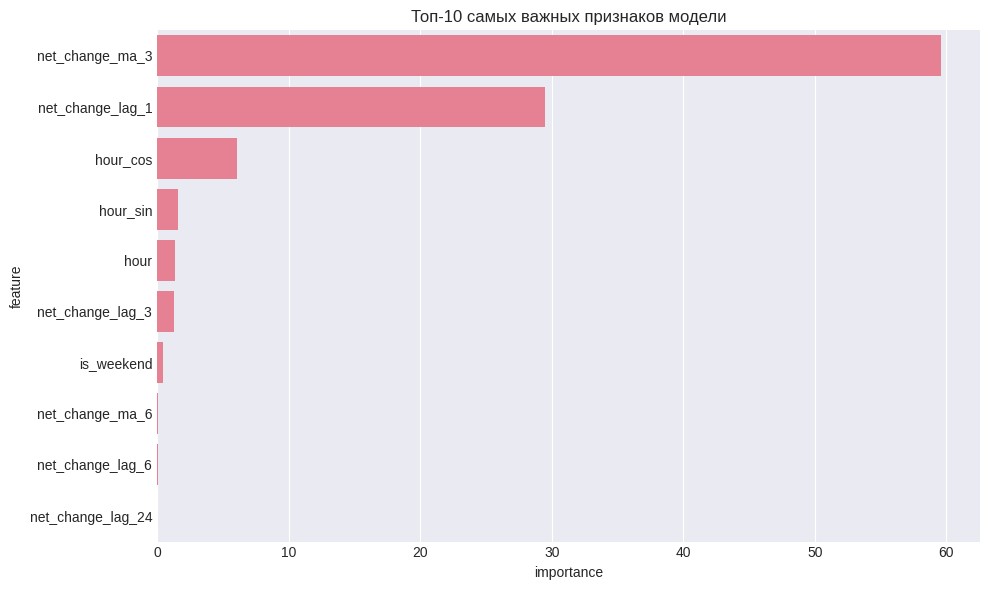

In [6]:
# 1. Загрузите сохранённые результаты для анализа
import pickle
import pandas as pd

with open('bike_demand_results_optimized.pkl', 'rb') as f:
    results = pickle.load(f)

# DataFrame с фактическими и предсказанными значениями
predictions_df = results['results_df']
print(predictions_df.head())

# 2. Проанализируйте важность признаков
import matplotlib.pyplot as plt
import seaborn as sns

# Создадим DataFrame из данных о важности признаков
feature_importance = pd.DataFrame({
    'feature': results['model_info']['feature_names'],
    'importance': results['model_info']['feature_importance']
}).sort_values('importance', ascending=False)

# Визуализируем топ-10 признаков
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance.head(10), x='importance', y='feature')
plt.title('Топ-10 самых важных признаков модели')
plt.tight_layout()
plt.savefig('top_10_features.png', dpi=120)
plt.show()

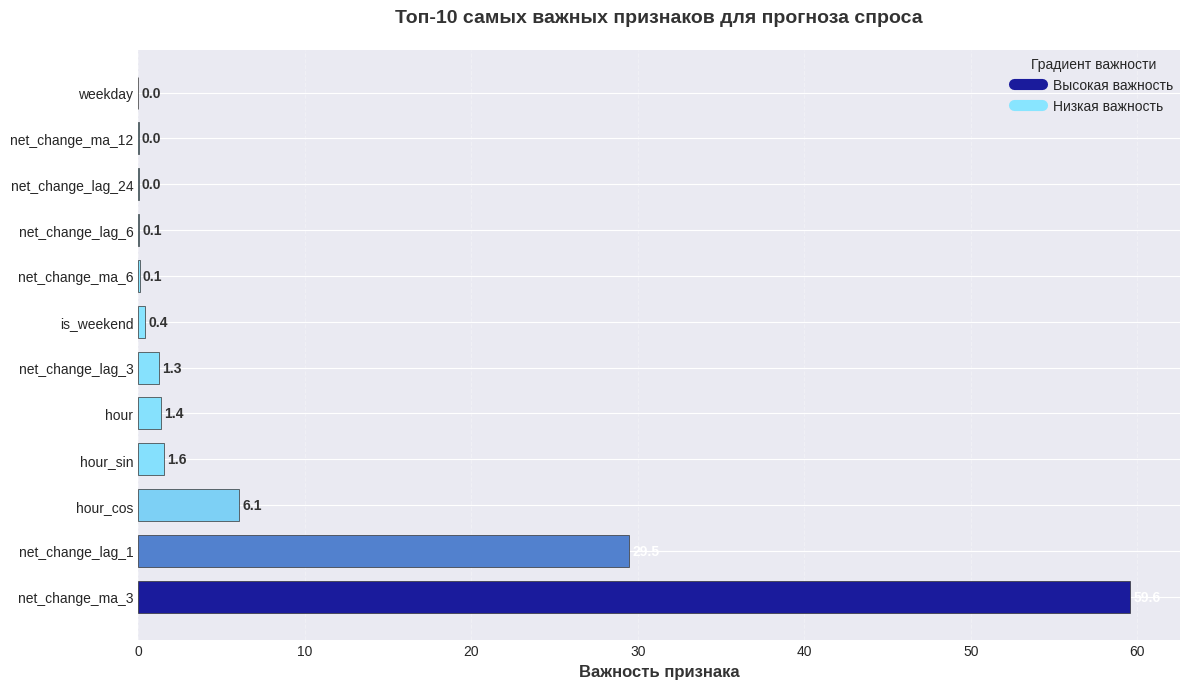

✅ График с градиентным оформлением сохранен как 'feature_importance_gradient.png'


In [15]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

# ============ КЛАСС GRADIENTCOLORS (ваш код) ============
class GradientColors:
    def __init__(self):
        # Основные цвета градиента (немного ярче)
        self.gradient_start = '#1a1b9c'  # Более яркий синий
        self.gradient_end = '#88e5ff'    # Более яркий голубой

        # Генерация градиентных цветов
        self.gradient_colors = self._generate_gradient(20)
        self.cmap = self._create_cmap()

    def _generate_gradient(self, n_colors):
        """Генерация градиента от темного к светлому"""
        # Конвертируем hex в RGB (значения от 0 до 1)
        def hex_to_rgb(hex_color):
            hex_color = hex_color.lstrip('#')
            return tuple(int(hex_color[i:i+2], 16)/255 for i in (0, 2, 4))

        start_rgb = hex_to_rgb(self.gradient_start)
        end_rgb = hex_to_rgb(self.gradient_end)

        # Создаем градиент
        colors = []
        for i in range(n_colors):
            t = i / (n_colors - 1)
            # Линейная интерполяция
            r = start_rgb[0] * (1 - t) + end_rgb[0] * t
            g = start_rgb[1] * (1 - t) + end_rgb[1] * t
            b = start_rgb[2] * (1 - t) + end_rgb[2] * t
            colors.append((r, g, b))

        return colors

    def _create_cmap(self):
        """Создание цветовой карты из градиента"""
        colors = self.gradient_colors
        # Создаем цветовую карту LinearSegmentedColormap
        cmap_dict = {
            'red': [],
            'green': [],
            'blue': []
        }

        n_colors = len(colors)
        for i, (r, g, b) in enumerate(colors):
            pos = i / (n_colors - 1) if n_colors > 1 else 0.5
            cmap_dict['red'].append((pos, r, r))
            cmap_dict['green'].append((pos, g, g))
            cmap_dict['blue'].append((pos, b, b))

        return LinearSegmentedColormap('custom_gradient', cmap_dict)

    def get_color(self, value, min_val=None, max_val=None, reversed=False):
        """Получить цвет из градиента на основе значения"""
        if min_val is None or max_val is None:
            # Если не заданы границы, возвращаем цвет по индексу
            if isinstance(value, int) and value < len(self.gradient_colors):
                return self.gradient_colors[value]
            else:
                return self.gradient_colors[0]

        if max_val == min_val:
            normalized = 0.5
        else:
            normalized = (value - min_val) / (max_val - min_val)

        if reversed:
            normalized = 1 - normalized

        # Используем цветовую карту для получения цвета
        return self.cmap(normalized)[:3]  # Возвращаем только RGB

    def get_gradient_for_values(self, values, reversed=False):
        """Получить список цветов для набора значений"""
        if len(values) == 0:
            return []

        min_val = min(values)
        max_val = max(values)

        colors = []
        for val in values:
            colors.append(self.get_color(val, min_val, max_val, reversed))

        return colors

# ============ ВИЗУАЛИЗАЦИЯ ВАЖНОСТИ ПРИЗНАКОВ ============
# Сортируем по убыванию важности
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Создаем градиентную цветовую схему
gradient_colors = GradientColors()

# Получаем цвета для каждого значения важности
colors = gradient_colors.get_gradient_for_values(
    feature_importance['importance'].values,
    reversed=True
)

# Создаем график
plt.figure(figsize=(12, 7))

# Создаем горизонтальные столбцы с градиентными цветами
bars = plt.barh(
    feature_importance['feature'],
    feature_importance['importance'],
    color=colors,
    edgecolor='#333333',
    linewidth=0.5,
    height=0.7
)

# УБИРАЕМ invert_yaxis() - теперь самый важный признак сверху
# plt.gca().invert_yaxis()  # Эта строка не нужна

# Настройки внешнего вида
plt.xlabel('Важность признака', fontsize=12, fontweight='bold', color='#333333')
plt.title('Топ-10 самых важных признаков для прогноза спроса',
          fontsize=14, fontweight='bold', pad=20, color='#333333')
plt.grid(axis='x', alpha=0.3, linestyle='--')

# Добавляем подписи значений на столбцах
for bar in bars:
    width = bar.get_width()
    # Выбираем цвет текста в зависимости от цвета столбца
    r, g, b = bar.get_facecolor()[:3]
    brightness = 0.299*r + 0.587*g + 0.114*b

    text_color = '#ffffff' if brightness < 0.5 else '#333333'

    plt.text(width + 0.2, bar.get_y() + bar.get_height()/2,
             f'{width:.1f}',
             ha='left', va='center',
             fontsize=10, fontweight='bold', color=text_color)

# Создаем кастомные элементы для легенды
legend_elements = [
    Line2D([0], [0], color=gradient_colors.gradient_start,
           lw=8, label='Высокая важность'),
    Line2D([0], [0], color=gradient_colors.gradient_end,
           lw=8, label='Низкая важность')
]

# ИЗМЕНЕНИЕ: Перемещаем легенду наверх, в правый угол
plt.legend(handles=legend_elements,
           loc='upper right',  # Изменено с 'lower right' на 'upper right'
           framealpha=0.9,
           title="Градиент важности",
           bbox_to_anchor=(1.0, 1.0),  # Привязка к верхнему правому углу
           borderaxespad=0.1)

plt.tight_layout()
plt.savefig('feature_importance_gradient.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ График с градиентным оформлением сохранен как 'feature_importance_gradient.png'")

In [17]:
!pip install contextily

In [21]:
# ==================== 1. ИМПОРТЫ (С ДОБАВЛЕНИЕМ ДЛЯ GRID SEARCH) ====================
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import pickle
import os
from pathlib import Path
import gc
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
from catboost import CatBoostRegressor, Pool

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
print("✅ Библиотеки загружены")

# ==================== 2. ИНКРЕМЕНТАЛЬНАЯ ЗАГРУЗКА И АГРЕГАЦИЯ ====================
print("\n" + "="*60)
print("ИНКРЕМЕНТАЛЬНАЯ ЗАГРУЗКА И АГРЕГАЦИЯ")
print("="*60)

file_paths = [
    '/content/drive/MyDrive/велики/rides_2021_optimized_filled.parquet',
    '/content/drive/MyDrive/велики/rides_2022_optimized_filled.parquet',
    '/content/drive/MyDrive/велики/rides_2023_optimized_filled.parquet',
    '/content/drive/MyDrive/велики/rides_2024_optimized_filled.parquet',
    '/content/drive/MyDrive/велики/rides_2025_optimized_filled.parquet'
]

def process_file_to_hourly(file_path, sample_frac=0.3):
    """Обрабатывает один файл и возвращает почасовые агрегаты."""
    print(f"Обработка {Path(file_path).name}...")

    try:
        # 1. Загрузка с выборкой и только нужных колонок
        usecols = ['started_at', 'ended_at', 'start_station_id', 'end_station_id']
        df = pd.read_parquet(file_path, columns=usecols)
        df = df.sample(frac=sample_frac, random_state=42) if sample_frac < 1 else df

        # 2. Оптимизированная предобработка
        df['started_at'] = pd.to_datetime(df['started_at'])
        df['ended_at'] = pd.to_datetime(df['ended_at'])
        df = df[df['ended_at'] > df['started_at']]

        # Создание временных признаков
        df['hour'] = df['started_at'].dt.hour
        df['weekday'] = df['started_at'].dt.weekday
        df['date_hour'] = df['started_at'].dt.floor('H')

        # Исправленная функция time_of_day (без np.select)
        def get_time_of_day(h):
            if 5 <= h < 12:
                return 'morning'
            elif 12 <= h < 17:
                return 'afternoon'
            elif 17 <= h < 22:
                return 'evening'
            else:
                return 'night'

        df['time_of_day'] = df['hour'].apply(get_time_of_day)

        # 3. Агрегация до почасовых данных (сразу в памяти)
        departures = df.groupby(['start_station_id', 'date_hour']).size().reset_index(name='departures')
        departures = departures.rename(columns={'start_station_id': 'station_id'})

        arrivals = df.groupby(['end_station_id', 'date_hour']).size().reset_index(name='arrivals')
        arrivals = arrivals.rename(columns={'end_station_id': 'station_id'})

        hourly = pd.merge(departures, arrivals, on=['station_id', 'date_hour'], how='outer').fillna(0)
        hourly['net_change'] = hourly['arrivals'] - hourly['departures']

        # Добавляем признаки времени
        hourly['hour'] = hourly['date_hour'].dt.hour
        hourly['weekday'] = hourly['date_hour'].dt.weekday
        hourly['is_weekend'] = (hourly['weekday'] >= 5).astype(int)

        print(f"   Создано {len(hourly):,} почасовых записей")
        return hourly

    except Exception as e:
        print(f"   Ошибка: {e}")
        return pd.DataFrame()
    finally:
        del df
        gc.collect()

# Обрабатываем файлы по очереди и сохраняем результаты
all_hourly_dfs = []
for file_path in tqdm(file_paths, desc="Обработка файлов"):
    hourly_df = process_file_to_hourly(file_path, sample_frac=0.3)
    if not hourly_df.empty:
        all_hourly_dfs.append(hourly_df)
    gc.collect()

# Объединяем все почасовые данные
if all_hourly_dfs:
    hourly_data = pd.concat(all_hourly_dfs, ignore_index=True)
    print(f"\n✅ ИТОГОВЫЕ ПОЧАСОВЫЕ ДАННЫЕ: {len(hourly_data):,} записей")
else:
    raise ValueError("Не удалось обработать ни один файл")

# Фильтруем только активные станции
station_activity = hourly_data.groupby('station_id')['departures'].sum()
active_stations = station_activity[station_activity >= 50].index
hourly_data = hourly_data[hourly_data['station_id'].isin(active_stations)]
print(f"   Активных станций: {hourly_data['station_id'].nunique()}")

# ==================== 3. СОЗДАНИЕ ПРИЗНАКОВ ДЛЯ ОБУЧЕНИЯ ====================
print("\n" + "="*60)
print("СОЗДАНИЕ ПРИЗНАКОВ ДЛЯ ОБУЧЕНИЯ")
print("="*60)

def create_features_for_training(hourly_data, top_n_stations=50):
    """Создает признаки для обучения, ограничиваясь топ-N станциями."""

    # Выбираем топ-N самых активных станций
    top_stations = hourly_data.groupby('station_id')['departures'].sum().nlargest(top_n_stations).index
    print(f"Выбираем топ-{top_n_stations} станций для обучения")

    features_list = []

    for station_id in tqdm(top_stations, desc="Создание признаков"):
        station_df = hourly_data[hourly_data['station_id'] == station_id].copy()
        station_df = station_df.sort_values('date_hour')

        if len(station_df) > 24:  # Нужно достаточно данных
            # Лаговые признаки
            for lag in [1, 3, 6, 24]:
                station_df[f'net_change_lag_{lag}'] = station_df['net_change'].shift(lag)

            # Скользящие средние
            for window in [3, 6, 12]:
                station_df[f'net_change_ma_{window}'] = station_df['net_change'].rolling(window=window, min_periods=1).mean()

            # Циклические признаки времени
            station_df['hour_sin'] = np.sin(2 * np.pi * station_df['hour'] / 24)
            station_df['hour_cos'] = np.cos(2 * np.pi * station_df['hour'] / 24)

            features_list.append(station_df)

    if not features_list:
        raise ValueError("Не удалось создать признаки")

    features_df = pd.concat(features_list, ignore_index=True)
    features_df = features_df.fillna(0)

    print(f"✅ Создано {len(features_df):,} записей с признаками")
    return features_df

# Создаем признаки
features_df = create_features_for_training(hourly_data, top_n_stations=50)

# Освобождаем память от hourly_data
del hourly_data
gc.collect()

# ==================== 4. ПОДГОТОВКА ДАННЫХ ====================
print("\n" + "="*60)
print("ПОДГОТОВКА ДАННЫХ ДЛЯ ОБУЧЕНИЯ")
print("="*60)

# Удаляем пропуски
features_df = features_df.dropna(subset=['net_change'])

# Определяем признаки и целевую переменную
exclude_cols = ['station_id', 'date_hour', 'arrivals', 'departures']
feature_cols = [col for col in features_df.columns if col not in exclude_cols + ['net_change']]

X = features_df[feature_cols]
y = features_df['net_change']

# Категориальные признаки (те, у которых мало уникальных значений)
cat_features = [col for col in X.columns if X[col].nunique() <= 10]

print(f"📊 Размерность данных:")
print(f"   X: {X.shape}, y: {y.shape}")
print(f"   Категориальных признаков: {len(cat_features)}")

# Разделение с учетом времени
time_idx = features_df['date_hour'].argsort()
X_sorted = X.iloc[time_idx]
y_sorted = y.iloc[time_idx]

split_idx = int(len(X_sorted) * 0.8)
X_train, X_test = X_sorted.iloc[:split_idx], X_sorted.iloc[split_idx:]
y_train, y_test = y_sorted.iloc[:split_idx], y_sorted.iloc[split_idx:]

print(f"\n🔀 Разделение:")
print(f"   Train: {len(X_train):,} записей")
print(f"   Test: {len(X_test):,} записей")

# ==================== 5. ПОДБОР ПАРАМЕТРОВ (ВМЕСТО GRID SEARCH) ====================
print("\n" + "="*60)
print("ПОДБОР ПАРАМЕТРОВ МОДЕЛИ")
print("="*60)

# Создаем функцию для оценки разных комбинаций параметров
def evaluate_catboost_params(X_train, y_train, X_val, y_val, cat_features, params, model_name):
    """Обучает CatBoost с заданными параметрами и возвращает метрики."""
    print(f"\n🧪 Тестирование: {model_name}")
    print(f"   Параметры: {params}")

    model = CatBoostRegressor(
        **params,
        loss_function='MAE',
        eval_metric='MAE',
        random_seed=42,
        task_type='CPU',
        verbose=0
    )

    # Обучаем с использованием валидационного набора для ранней остановки
    model.fit(
        X_train, y_train,
        eval_set=(X_val, y_val),
        cat_features=cat_features,
        early_stopping_rounds=50,
        verbose=0
    )

    # Предсказания
    y_pred = model.predict(X_val)
    mae = mean_absolute_error(y_val, y_pred)

    print(f"   MAE на валидации: {mae:.4f}")
    print(f"   Итераций выполнено: {model.tree_count_}")

    return model, mae

# Разделим обучающую выборку на train и validation
split_idx_val = int(len(X_train) * 0.8)
X_train_small, X_val = X_train.iloc[:split_idx_val], X_train.iloc[split_idx_val:]
y_train_small, y_val = y_train.iloc[:split_idx_val], y_train.iloc[split_idx_val:]

print(f"Создаем validation set для подбора параметров:")
print(f"   Train (для подбора): {len(X_train_small):,} записей")
print(f"   Validation: {len(X_val):,} записей")

# Определяем различные комбинации параметров для тестирования
param_combinations = [
    {
        'name': 'Быстрая (неглубокая)',
        'iterations': 800,
        'learning_rate': 0.1,
        'depth': 4,
        'l2_leaf_reg': 3,
        'bagging_temperature': 1
    },
    {
        'name': 'Стандартная',
        'iterations': 1000,
        'learning_rate': 0.05,
        'depth': 6,
        'l2_leaf_reg': 3,
        'bagging_temperature': 0.5
    },
    {
        'name': 'Глубокая',
        'iterations': 1200,
        'learning_rate': 0.03,
        'depth': 8,
        'l2_leaf_reg': 1,
        'bagging_temperature': 0
    },
    {
        'name': 'Регуляризованная',
        'iterations': 800,
        'learning_rate': 0.07,
        'depth': 6,
        'l2_leaf_reg': 10,
        'bagging_temperature': 1
    },
    {
        'name': 'Консервативная',
        'iterations': 1500,
        'learning_rate': 0.02,
        'depth': 10,
        'l2_leaf_reg': 5,
        'bagging_temperature': 0.5
    }
]

# Тестируем разные комбинации параметров
results = []
best_mae = float('inf')
best_model = None
best_params = None

for param_set in param_combinations:
    name = param_set.pop('name')
    model, mae = evaluate_catboost_params(
        X_train_small, y_train_small, X_val, y_val, cat_features, param_set, name
    )

    results.append({
        'name': name,
        'mae': mae,
        'params': param_set.copy(),
        'model': model
    })

    if mae < best_mae:
        best_mae = mae
        best_model = model
        best_params = param_set.copy()

    param_set['name'] = name  # Возвращаем имя обратно

# Выводим результаты
print("\n" + "="*60)
print("РЕЗУЛЬТАТЫ ПОДБОРА ПАРАМЕТРОВ")
print("="*60)

results_df = pd.DataFrame(results)
results_df = results_df.sort_values('mae')
print("\n📊 Сравнение моделей (от лучшей к худшей):")
for idx, row in results_df.iterrows():
    print(f"   {row['name']}: MAE = {row['mae']:.4f}")

print(f"\n🏆 ЛУЧШАЯ МОДЕЛЬ: {results_df.iloc[0]['name']}")
print(f"   MAE: {results_df.iloc[0]['mae']:.4f}")
print(f"   Параметры: {results_df.iloc[0]['params']}")

# ==================== 6. ОБУЧЕНИЕ ФИНАЛЬНОЙ МОДЕЛИ С ЛУЧШИМИ ПАРАМЕТРАМИ ====================
print("\n" + "="*60)
print("ОБУЧЕНИЕ ФИНАЛЬНОЙ МОДЕЛИ С ЛУЧШИМИ ПАРАМЕТРАМИ")
print("="*60)

# Используем лучшие параметры для обучения на полном тренировочном наборе
final_params = results_df.iloc[0]['params'].copy()

# Добавляем дополнительные параметры
final_params.update({
    'loss_function': 'MAE',
    'eval_metric': 'MAE',
    'random_seed': 42,
    'task_type': 'CPU',
    'verbose': 100,
    'early_stopping_rounds': 50,
    'use_best_model': True
})

print(f"🚀 Начинаем обучение финальной модели с параметрами:")
for key, value in final_params.items():
    print(f"   {key}: {value}")

final_model = CatBoostRegressor(**final_params)

# Обучаем на полном тренировочном наборе
final_model.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    cat_features=cat_features,
    verbose_eval=100,
    plot=False
)
print("✅ Обучение завершено!")

# ==================== 7. ОЦЕНКА И СОХРАНЕНИЕ РЕЗУЛЬТАТОВ ====================
print("\n" + "="*60)
print("ОЦЕНКА МОДЕЛИ И СОХРАНЕНИЕ РЕЗУЛЬТАТОВ")
print("="*60)

# Предсказания и метрики
y_pred = final_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"📊 РЕЗУЛЬТАТЫ ФИНАЛЬНОЙ МОДЕЛИ:")
print(f"   MAE:  {mae:.2f}")
print(f"   RMSE: {rmse:.2f}")
print(f"   R²:   {r2:.3f}")

# Сравнение с базовой моделью
print(f"\n📈 СРАВНЕНИЕ С БАЗОВЫМИ ПАРАМЕТРАМИ:")
print("Обучение базовой модели для сравнения...")
base_model = CatBoostRegressor(
    iterations=800,
    learning_rate=0.05,
    depth=6,
    l2_leaf_reg=3,
    loss_function='MAE',
    eval_metric='MAE',
    random_seed=42,
    task_type='CPU',
    verbose=0,
    early_stopping_rounds=50,
    use_best_model=True
)
base_model.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    cat_features=cat_features,
    verbose=0
)
y_pred_base = base_model.predict(X_test)
mae_base = mean_absolute_error(y_test, y_pred_base)
print(f"   Базовая модель MAE: {mae_base:.2f}")
print(f"   Улучшение: {(mae_base - mae):.2f} ({((mae_base - mae)/mae_base*100):.1f}%)")

# Анализ важности признаков
feature_importance = final_model.get_feature_importance()
feature_importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("\n🔝 Топ-10 важных признаков:")
print(feature_importance_df.head(10))

# Сохраняем результаты для визуализации
results_df = pd.DataFrame({
    'station_id': features_df.iloc[X_test.index]['station_id'].values,
    'date_hour': features_df.iloc[X_test.index]['date_hour'].values,
    'actual_net_change': y_test.values,
    'predicted_net_change': y_pred,
    'predicted_base': y_pred_base,
    'actual_arrivals': features_df.iloc[X_test.index]['arrivals'].values,
    'actual_departures': features_df.iloc[X_test.index]['departures'].values,
    'error': y_pred - y_test.values,
    'error_base': y_pred_base - y_test.values
})

# Сохраняем модель и результаты
model_filename = 'bike_demand_model_optimized_tuned.cbm'
final_model.save_model(model_filename)
results_df.to_csv('bike_demand_predictions_tuned.csv', index=False)

# Сохраняем полные результаты в pickle
results_data = {
    'results_df': results_df,
    'model_metrics': {
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2,
        'MAE_base': mae_base,
        'improvement': mae_base - mae
    },
    'all_model_results': [
        {
            'name': r['name'],
            'mae': r['mae'],
            'params': r['params']
        } for r in results
    ],
    'best_params': results_df.iloc[0]['params'],
    'model_info': {
        'feature_importance': feature_importance.tolist(),
        'feature_names': feature_cols,
        'cat_features': cat_features,
        'feature_importance_df': feature_importance_df
    },
    'data_info': {
        'train_size': len(X_train),
        'test_size': len(X_test),
        'n_stations': features_df['station_id'].nunique()
    },
    'timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S")
}

with open('bike_demand_results_tuned.pkl', 'wb') as f:
    pickle.dump(results_data, f)

print(f"\n💾 РЕЗУЛЬТАТЫ СОХРАНЕНЫ:")
print(f"   1. Модель: {model_filename}")
print(f"   2. Предсказания (CSV): bike_demand_predictions_tuned.csv")
print(f"   3. Все данные (Pickle): bike_demand_results_tuned.pkl")
print(f"   4. Лучшие параметры: {results_df.iloc[0]['params']}")

# ==================== 8. ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ ====================
print("\n" + "="*60)
print("ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ")
print("="*60)

# Создаем директорию для графиков
os.makedirs('plots', exist_ok=True)

# 1. График сравнения моделей по MAE
plt.figure(figsize=(10, 6))
models = [r['name'] for r in results]
mae_scores = [r['mae'] for r in results]
colors = plt.cm.Set3(np.linspace(0, 1, len(models)))

bars = plt.bar(models, mae_scores, color=colors)
plt.xlabel('Модель')
plt.ylabel('MAE')
plt.title('Сравнение моделей по MAE (меньше - лучше)')
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3, axis='y')

# Добавляем значения на столбцы
for bar, score in zip(bars, mae_scores):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{score:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.savefig('plots/model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# 2. График сравнения фактических и предсказанных значений
plt.figure(figsize=(12, 6))
plt.scatter(y_test[:500], y_pred[:500], alpha=0.6, s=10, label='Настроенная модель')
plt.scatter(y_test[:500], y_pred_base[:500], alpha=0.6, s=10, label='Базовая модель')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Фактическое изменение велосипедов')
plt.ylabel('Предсказанное изменение велосипедов')
plt.title(f'Сравнение моделей (MAE: {mae:.2f} vs {mae_base:.2f})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('plots/actual_vs_predicted_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# 3. График важности признаков
plt.figure(figsize=(10, 8))
top_features = feature_importance_df.head(15)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Важность признака')
plt.title('Топ-15 важных признаков')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('plots/feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

# 4. График ошибок по времени (для одной станции)
sample_station = results_df['station_id'].value_counts().index[0]
station_results = results_df[results_df['station_id'] == sample_station].copy()
station_results = station_results.sort_values('date_hour')

plt.figure(figsize=(14, 6))
plt.plot(station_results['date_hour'], station_results['actual_net_change'],
         label='Фактическое', alpha=0.7, linewidth=1)
plt.plot(station_results['date_hour'], station_results['predicted_net_change'],
         label='Настроенная модель', alpha=0.7, linewidth=1, linestyle='--')
plt.plot(station_results['date_hour'], station_results['predicted_base'],
         label='Базовая модель', alpha=0.7, linewidth=1, linestyle=':')
plt.fill_between(station_results['date_hour'],
                 station_results['predicted_net_change'] - mae,
                 station_results['predicted_net_change'] + mae,
                 alpha=0.2, color='orange', label=f'±MAE ({mae:.1f})')
plt.xlabel('Время')
plt.ylabel('Изменение велосипедов')
plt.title(f'Предсказание для станции {sample_station}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('plots/time_series_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# 5. Распределение ошибок
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(results_df['error'], bins=50, alpha=0.7, edgecolor='black', color='blue')
axes[0].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[0].set_xlabel('Ошибка предсказания (настроенная)')
axes[0].set_ylabel('Частота')
axes[0].set_title(f'Настроенная модель (Среднее: {results_df["error"].mean():.2f})')
axes[0].grid(True, alpha=0.3)

axes[1].hist(results_df['error_base'], bins=50, alpha=0.7, edgecolor='black', color='green')
axes[1].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[1].set_xlabel('Ошибка предсказания (базовая)')
axes[1].set_ylabel('Частота')
axes[1].set_title(f'Базовая модель (Среднее: {results_df["error_base"].mean():.2f})')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('plots/error_distribution_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n" + "="*60)
print("ИНФОРМАЦИЯ О МОДЕЛИ")
print("="*60)
print(f"🎯 Лучшая модель: {results_df.iloc[0]['name']}")
print(f"📊 Метрики:")
print(f"   - MAE: {mae:.2f} (улучшение на {(mae_base - mae):.2f} или {((mae_base - mae)/mae_base*100):.1f}%)")
print(f"   - RMSE: {rmse:.2f}")
print(f"   - R²: {r2:.3f}")
print(f"\n🔧 Использованные параметры:")
for key, value in final_params.items():
    if key not in ['loss_function', 'eval_metric', 'random_seed', 'task_type', 'verbose', 'use_best_model']:
        print(f"   {key}: {value}")

print("\n✅ ВСЕ ЭТАПЫ ЗАВЕРШЕНЫ!")

✅ Библиотеки загружены

ИНКРЕМЕНТАЛЬНАЯ ЗАГРУЗКА И АГРЕГАЦИЯ


Обработка файлов:   0%|          | 0/5 [00:00<?, ?it/s]

Обработка rides_2021_optimized_filled.parquet...
   Создано 1,170,815 почасовых записей


Обработка файлов:  20%|██        | 1/5 [00:05<00:23,  5.79s/it]

Обработка rides_2022_optimized_filled.parquet...


Обработка файлов:  40%|████      | 2/5 [00:10<00:15,  5.28s/it]

   Создано 1,438,337 почасовых записей
Обработка rides_2023_optimized_filled.parquet...
   Создано 1,479,842 почасовых записей


Обработка файлов:  60%|██████    | 3/5 [00:19<00:13,  6.91s/it]

Обработка rides_2024_optimized_filled.parquet...


Обработка файлов:  80%|████████  | 4/5 [00:25<00:06,  6.63s/it]

   Создано 1,463,421 почасовых записей
Обработка rides_2025_optimized_filled.parquet...
   Создано 1,263,663 почасовых записей


Обработка файлов: 100%|██████████| 5/5 [00:33<00:00,  6.70s/it]



✅ ИТОГОВЫЕ ПОЧАСОВЫЕ ДАННЫЕ: 6,816,078 записей
   Активных станций: 1927

СОЗДАНИЕ ПРИЗНАКОВ ДЛЯ ОБУЧЕНИЯ
Выбираем топ-50 станций для обучения


Создание признаков: 100%|██████████| 50/50 [00:34<00:00,  1.45it/s]


✅ Создано 1,030,772 записей с признаками

ПОДГОТОВКА ДАННЫХ ДЛЯ ОБУЧЕНИЯ
📊 Размерность данных:
   X: (1030772, 12), y: (1030772,)
   Категориальных признаков: 2

🔀 Разделение:
   Train: 824,617 записей
   Test: 206,155 записей

ПОДБОР ПАРАМЕТРОВ МОДЕЛИ
Создаем validation set для подбора параметров:
   Train (для подбора): 659,693 записей
   Validation: 164,924 записей

🧪 Тестирование: Быстрая (неглубокая)
   Параметры: {'iterations': 800, 'learning_rate': 0.1, 'depth': 4, 'l2_leaf_reg': 3, 'bagging_temperature': 1}
   MAE на валидации: 1.0292
   Итераций выполнено: 800

🧪 Тестирование: Стандартная
   Параметры: {'iterations': 1000, 'learning_rate': 0.05, 'depth': 6, 'l2_leaf_reg': 3, 'bagging_temperature': 0.5}
   MAE на валидации: 1.0177
   Итераций выполнено: 1000

🧪 Тестирование: Глубокая
   Параметры: {'iterations': 1200, 'learning_rate': 0.03, 'depth': 8, 'l2_leaf_reg': 1, 'bagging_temperature': 0}
   MAE на валидации: 1.0121
   Итераций выполнено: 1200

🧪 Тестирование: Регуляризо

KeyError: 'params'